# The notebook performs exploratory data analysis (EDA) on the SGIJ dataset

In [1]:
import math
from datetime import date
from datetime import datetime
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib
import matplotlib.pyplot as plt
import mysql.connector
from sklearn.cluster import KMeans
from sklearn import metrics
%matplotlib inline

register_matplotlib_converters()

Connect to MySQL databasef from credentials

In [2]:
config = {
  'user': 'root',
  'password': 'thingtrack',
  'host': '127.0.0.1',
  'database': 'gaming',
  'raise_on_warnings': True,
  'charset': 'utf8'
}

try:
  cnx = mysql.connector.connect(**config)
except mysql.connector.Error as err:
  if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
    print("Something is wrong with your user name or password")
  elif err.errno == errorcode.ER_BAD_DB_ERROR:
    print("Database does not exist")
  else:
    print(err)

## Sex player distribution

Get raw Dataset

In [3]:
cursor = cnx.cursor()

query = ("SELECT pl.sex, COUNT(pl.sex) as total"
         " FROM player pl"
         " GROUP BY pl.sex"
         " ORDER BY pl.sex")

cursor.execute(query)

# return a list of tuples
result_sex = list(cursor.fetchall())

Plot sex distribution Dataset

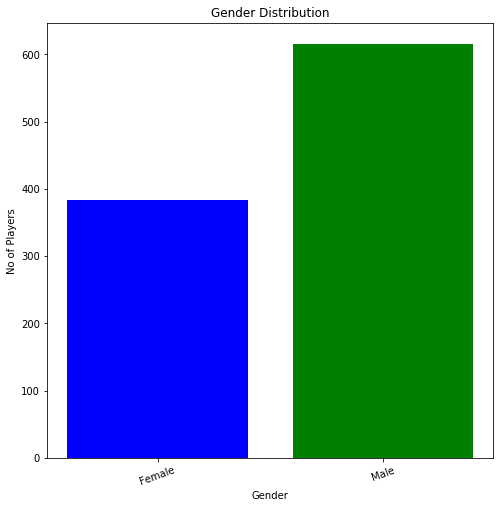

In [4]:
data = np.array(result_sex) # numpy convert to string all values
labels = data[:, 0]
values = data[:, 1].astype(int)
    
plt.figure(figsize=(8, 8))  
plt.bar(labels, values, color=('blue', 'green'))
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('No of Players')
plt.xticks(np.arange(labels.size), ('Female', 'Male'), rotation=20)
plt.show()

## Betting Intensity (number of bettings during a period of time called account event)

Get raw Dataset for players with more that 8 beetings at least during a account event from a minimun-maximun of 6-10 bettings

In [5]:
cursor = cnx.cursor()

query = ("SELECT @rownum:=@rownum+1 AS row_num, SUM(bettings) as total"
         " FROM (SELECT @rownum:=0) r, player pl, account ac"
         " WHERE pl.operator_id = ac.operator_id"
         " AND pl.player_id = ac.player_id"
         " AND ac.bettings > 8"
         " GROUP BY pl.operator_id, pl.player_id;")

cursor.execute(query)

# return a list of tuples
result_bettings = list(cursor.fetchall())

Plot betting frecuency distribution Dataset

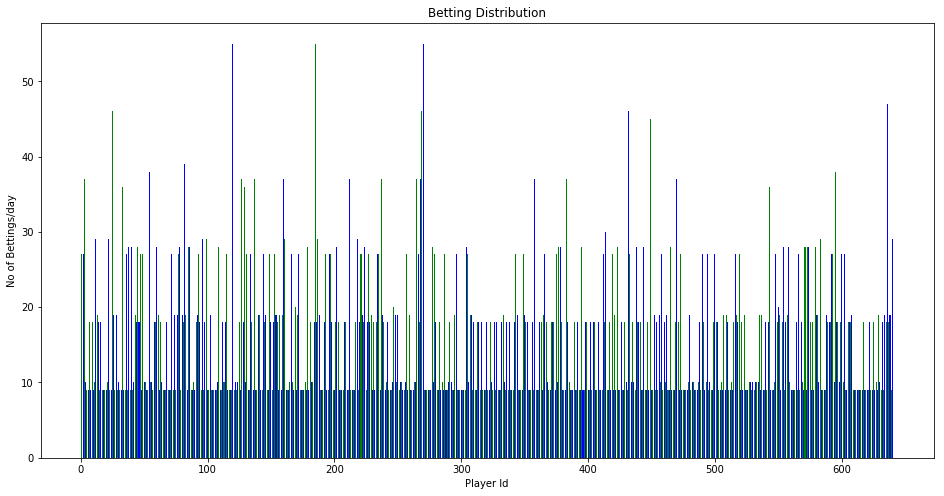

In [6]:
data = np.array(result_bettings) # numpy convert to string all values
labels = data[:, 0]
values = data[:, 1].astype(int)

plt.figure(figsize=(16, 8))  
plt.bar(labels, values, color=('green', 'blue'))
plt.title('Betting Distribution')
plt.xlabel('Player Id')
plt.ylabel('No of Bettings/day')
plt.show()

## Clustering profit by birthdate player

Get raw Dataset

In [7]:
# create dataset from database
cursor = cnx.cursor()

query = ("SELECT pl.birthdate, SUM(ac.profit) AS profit"
         " FROM player pl, account ac"
         " WHERE pl.operator_id = ac.operator_id"
         " AND pl.player_id = ac.player_id"
         " GROUP BY ac.operator_id, ac. player_id")

cursor.execute(query)

# return a list of tuples
result_km_players = list(cursor.fetchall())

Transform date characteristics and create tuples

In [8]:
# separate tuples
dates, profits = zip(*result_km_players)

# convert string to date
#dates = [pd.to_datetime(d) for d in dates]

helper = np.vectorize(lambda x: datetime.combine(x, datetime.min.time()).timestamp())

X = []
for row in result_km_players:
    X.append([helper(row[0]), row[1]])

Plot Age vs Profit Scatter Plot

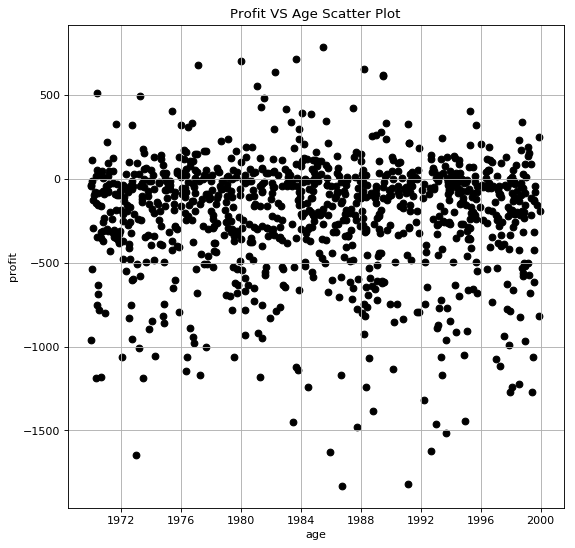

In [9]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(dates, profits, color='k')
plt.title("Profit VS Age Scatter Plot")
plt.xlabel("age")
plt.ylabel("profit")
plt.grid()
plt.show()

Design de k-means with 2 clusters model for dataset

In [10]:
model = KMeans(n_clusters=2).fit(X)

Print k-means centroides

In [11]:
centroides = []
for row in model.cluster_centers_:
    centroides.append((datetime.fromtimestamp(int(round(row[0]))), row[1]))

print(centroides)    

centroides_dates, centroides_profits = zip(*centroides)

[(datetime.datetime(1977, 7, 12, 17, 11, 24), -203.2495049504955), (datetime.datetime(1992, 7, 7, 5, 6, 4), -242.3494949494953)]


Plot the scatter plot and the centroides for tha dataset

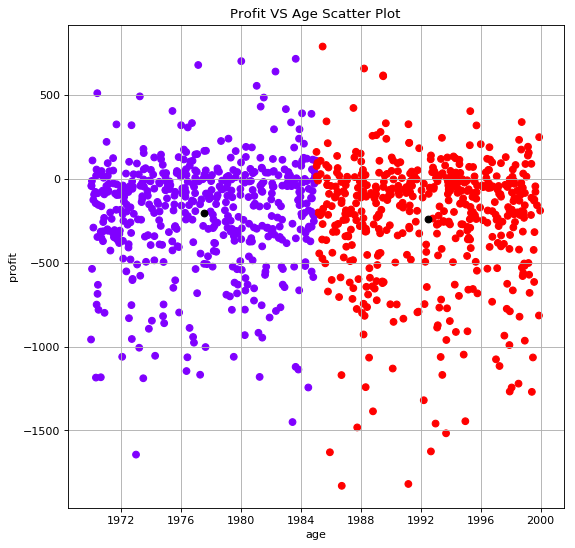

In [12]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(dates, profits, c=model.labels_, cmap='rainbow')
plt.scatter(centroides_dates ,centroides_profits, color='black')
plt.title("Profit VS Age Scatter Plot")
plt.xlabel("age")
plt.ylabel("profit")
plt.grid()
plt.show()